<a href="https://colab.research.google.com/github/dipayandas97/Deep-Learning-Notebooks/blob/master/Animal_10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, utils

##Transforms classes


In [ ]:
class Reshape(object):
    def __init__(self,out_shape: tuple):
        self.out_w, self.out_h = out_shape[0], out_shape[1]
    
    def __call__(self,image):
        return cv2.resize(image, (self.out_w,self.out_h))

class RandomCrop(object):
    def __init__(self, out_shape: tuple):
        self.out_w, self.out_h = int(out_shape[0]), int(out_shape[1])
        
    def __call__(self,image):     
        assert self.out_h < image.shape[0]
        assert self.out_w < image.shape[1]
        
        h, w = image.shape[0], image.shape[1]
        top = np.random.randint(0, h - self.out_h, 1).astype(int)[0]
        left = np.random.randint(0, w - self.out_w, 1).astype(int)[0]
        
        return image[top:top+self.out_h,left:left+self.out_w]

class RandomHorizontalFlip(object):
    def __call__(self, image):
        if np.random.uniform(0.0,1.0,1) > 0.5:
            return np.flip(image, axis=1).copy()
        else:
            return image

class ToTensor(object):
    '''
    Args:
        numpy image (H,W,C) range: (0,255)
    Returns:
        torch float tensor (C,H,W) range: (0,1)
    '''
    def __call__(self, image):
        #numpy image shape : (H, W, C)
        #torch image shape : (C, H, W)

        image = image.transpose((2,0,1))
        return torch.from_numpy(image.astype(np.float)/255.0)

class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t,m,s in zip(tensor, self.mean, self.std):
            t.sub_(m).div_(s)        
        return tensor

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


##Dataset class

In [ ]:
class animal_dataset(Dataset):
    def __init__(self, filenames, labels, class_names, transforms, translation_dict, rev_translation_dict):
        
        self.filenames, self.labels = filenames, labels
        self.class_names = class_names
        self.transforms = transforms
        self.translation_dict = translation_dict
        self.rev_translation_dict = rev_translation_dict
        
        self.class_name_label_encoder = {}
        for idx,name in enumerate(self.class_names):
            self.class_name_label_encoder[name] = idx

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        path, label = self.filenames[idx], self.labels[idx]

        #Extract and pre-process image
        image = cv2.imread(path)
        if self.transforms:
            image = self.transforms(image)
        
        #Encode label
        label_encoded_label = self.class_name_label_encoder[label]
        
        return image, label_encoded_label
        

In [ ]:
 #Dataset directory
dataset_dir_path = '/content/drive/MyDrive/Dataset_Cache/animal_10/raw_img/'
translation_dict = {
             "cane": "dog", 
             "cavallo": "horse", 
             "elefante": "elephant",
             "farfalla": "butterfly",
             "gallina": "chicken", 
             "gatto": "cat", 
             "mucca": "cow", 
             "pecora": "sheep",
             "scoiattolo": "squirrel", 
             "ragno": "spider"}
rev_translation_dict = {
             "dog": "cane", 
             "horse": "cavallo",
             "elephant" : "elefante", 
             "butterfly": "farfalla",
             "chicken": "gallina", 
             "cat": "gatto",
             "cow": "mucca",
             "sheep": "pecora",
             "spider": "ragno",
             "squirrel": "scoiattolo"}

#Obtain class names and translate
class_names = os.listdir(dataset_dir_path)
for idx,name in enumerate(class_names):
    class_names[idx] = translation_dict[name]
print('Class_names : ',class_names)

#Generate all filepaths and corresponding labels
filenames, labels = [], []
for class_name in class_names:
    path = os.path.join(dataset_dir_path, rev_translation_dict[class_name])
    images = os.listdir(path)
    for image_name in images:
        filenames.append(os.path.join(path,image_name))
        labels.append(class_name)
filenames = np.asarray(filenames)
labels = np.asarray(labels)

#Shuffle
idxs = np.asarray([x for x in range(len(filenames))])
np.random.shuffle(idxs)
filenames[:] = filenames[idxs]
labels[:] = labels[idxs]

#Train Test split 
split = 0.1
split_idx = int(split * len(filenames))
train_filenames, train_labels = filenames[split_idx:], labels[split_idx:]
val_filenames, val_labels = filenames[:split_idx], labels[:split_idx]
print('Train shape:',train_filenames.shape, train_labels.shape)
print('Val shape:',val_filenames.shape, val_labels.shape)

#Compose transforms
train_composed_transforms = transforms.Compose([Reshape((256,256)),
                                          RandomCrop((224,224)),
                                          RandomHorizontalFlip(),
                                          ToTensor(),
                                          Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                                          ])
val_composed_transforms = transforms.Compose([Reshape((224,224)),
                                          #RandomCrop((224,224)),
                                          #RandomHorizontalFlip(),
                                          ToTensor(),
                                          Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                                          ])

#Make animal dataset object
train_animal_dataset = animal_dataset(filenames=train_filenames,
                                      labels = train_labels,
                                      class_names = class_names,
                                      transforms = train_composed_transforms,
                                      translation_dict = translation_dict, 
                                      rev_translation_dict = rev_translation_dict)
val_animal_dataset = animal_dataset(filenames=val_filenames,
                                    labels = val_labels,
                                    class_names = class_names,
                                    transforms = val_composed_transforms,
                                    translation_dict = translation_dict, 
                                    rev_translation_dict = rev_translation_dict)


Class_names :  ['squirrel', 'elephant', 'dog', 'chicken', 'spider', 'cat', 'horse', 'sheep', 'cow', 'butterfly']
Train shape: (23562,) (23562,)
Val shape: (2617,) (2617,)


2 
torch.Size([3, 224, 224])


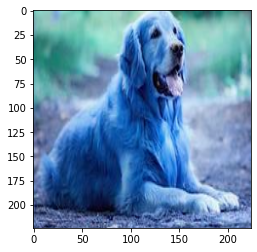

8 
torch.Size([3, 224, 224])


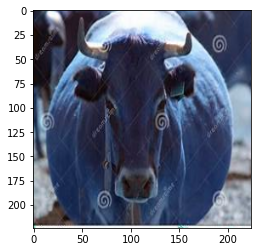

2 
torch.Size([3, 224, 224])


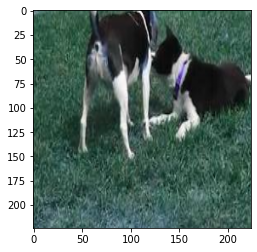

6 
torch.Size([3, 224, 224])


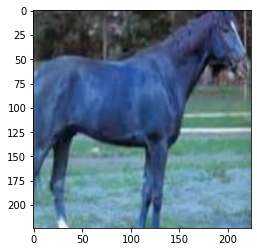

2 
torch.Size([3, 224, 224])


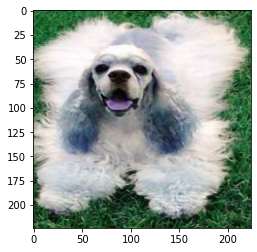

6 
torch.Size([3, 224, 224])


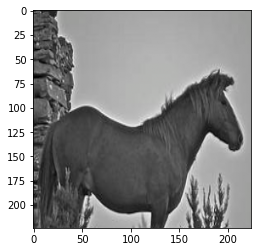

In [ ]:
#With normalization - unnormalization

unnormalize = UnNormalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])

for i in range(0,len(train_animal_dataset),len(train_animal_dataset)//5):
    image, label = train_animal_dataset[i]
    print(label, _)
    print(image.shape)
    plt.imshow(unnormalize(image).permute(1,2,0))
    plt.show()

#print('Normed Image',image)
#print('Unnormed Image', unnormalize(image))

##DataLoader

In [ ]:
train_loader = DataLoader(train_animal_dataset, 
                               batch_size=32, 
                               shuffle=True, 
                               num_workers=10)

val_loader = DataLoader(val_animal_dataset, 
                               batch_size=32, 
                               shuffle=True, 
                               num_workers=10)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#Network

##From scratch

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_1 = nn.Conv2d(3, 16, 5) #(in_channel, out_channel, kernel_size)
        self.pool_1 = nn.MaxPool2d(2, 2) #(kernel size)

        self.conv_2 = nn.Conv2d(16, 64, 3)
        self.pool_2 = nn.MaxPool2d(2, 2)

        self.conv_3 = nn.Conv2d(64, 128, 3)
        self.pool_3 = nn.MaxPool2d(2,2)

        self.conv_4 = nn.Conv2d(128, 256, 3)
        self.pool_4 = nn.MaxPool2d(2,2)

        self.fc_1 = nn.Linear(256, 128)
        self.fc_2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool_1(F.relu(self.conv_1(x)))
        x = self.pool_2(F.relu(self.conv_2(x)))
        x = self.pool_3(F.relu(self.conv_3(x)))
        x = self.pool_4(F.relu(self.conv_4(x)))
        x = F.avg_pool2d(x,12)
        x = torch.flatten(x, 1)

        x = F.relu(self.fc_1(x))
        x = F.softmax(self.fc_2(x),dim=1)

        return x

#classifier = Classifier().to(device)


##Pre-trained : ResNet-34

In [ ]:
from torchvision import models

classifier = models.resnet34(pretrained=True)
in_feats = classifier.fc.in_features
classifier.fc = nn.Linear(in_feats, 10)
classifier = classifier.to(device)

#Training Routine

In [ ]:
#Loss function and Optimizer
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', patience=5, factor=0.5, min_lr=1e-7)

def accuracy(output, encoded_label):
    label_encoded_output = torch.argmax(output, dim=1)
    acc = torch.sum(label_encoded_output==encoded_label).item() / label_encoded_output.size(0)
    return acc    

In [ ]:
#Training routine
from tqdm.notebook import tqdm as tqdm

epochs = 4
batch_size = 32

for epoch in range(epochs):
    print('Epoch: ',epoch)
    #Train
    running_loss, running_acc = 0, 0
    for idx,(image, encoded_label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        image, label = image.to(device), encoded_label.to(device)
        optimizer.zero_grad()

        output = classifier(image.float())
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(output.detach(), label)

    print('Training loss: ',running_loss/(idx+1))
    print('Training acc.: ',running_acc/(idx+1))

    #Validate
    running_loss, running_acc = 0, 0
    for idx,(image, encoded_label) in tqdm(enumerate(val_loader), total=len(val_loader)):
        image, label = image.to(device), encoded_label.to(device)
        with torch.no_grad():
            output = classifier(image.float())
            loss = criterion(output, label)

            running_loss += loss.item()
            running_acc += accuracy(output.detach(), label)

    print('Validation loss: ',running_loss/(idx+1))
    print('Validation acc.: ',running_acc/(idx+1))
    scheduler.step(running_loss/(idx+1))
    print('_______________________________________________________')
   
    

Epoch:  0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Training loss:  0.23548763658436903
Training acc.:  0.9286210990502035



Validation loss:  0.21763218905231574
Validation acc.:  0.9333689024390244
_______________________________________________________
Epoch:  1



Training loss:  0.12222912050644631
Training acc.:  0.9636618046132972



Validation loss:  0.17792124452251123
Validation acc.:  0.9441463414634147
_______________________________________________________
Epoch:  2



Training loss:  0.08927650026234026
Training acc.:  0.9722099728629578



Validation loss:  0.19192912292144285
Validation acc.:  0.9464329268292683
_______________________________________________________
Epoch:  3
